In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.linear_model import LogisticRegression

# Added imports
import networkx as nx
from networkx.algorithms import bipartite

%matplotlib inline

# Question 1: Propensity Score Matching

In [132]:
data = pd.read_csv('Homework4-data/lalonde.csv', dtype={
    'treat': np.bool_,
    'age': np.uint8,
    'age': np.uint8,
    'nodegree': np.bool_,
    'married': np.bool_,
    'black': np.bool_,
    'hispan': np.bool_,
    're74': np.float32,
    're75': np.float32,
    're78': np.float32
})

In [133]:
display(data.head())

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886


## 1 - A naive analysis

In [134]:
treated_revenues = data.re78[data.treat == True]

In [135]:
print("Treated revenues in 1978:\n", treated_revenues.describe())

Treated revenues in 1978:
 count      185.000000
mean      6349.145508
std       7867.402344
min          0.000000
25%        485.229797
50%       4232.309082
75%       9642.999023
max      60307.929688
Name: re78, dtype: float64


In [136]:
not_treated_revenues = data.re78[data.treat == False]

In [137]:
print("Not treated revenues in 1978:\n", not_treated_revenues.describe())

Not treated revenues in 1978:
 count      429.000000
mean      6984.169434
std       7294.164551
min          0.000000
25%        220.181305
50%       4975.504883
75%      11688.820312
max      25564.669922
Name: re78, dtype: float64


In [138]:
def empirical_distribution(data):
    """Computes the empirical distribution of the provided pandas series"""
    return data.value_counts().sort_index().cumsum() / len(data)

We display the earnings in 1978 using boxplots. Remark that to compare and draw conclusions, it is important to use the same scale for the two data series (`sharey='row'` and `sharex='row'`)

We define functions to print the earning because they will be re-used later in the analysis

In [139]:
def print_box_1978_earnings(treated, not_treated):
    """This function will print the 1978 earnings depending on the """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                   sharey='row', sharex='row',
                                   figsize=(10, 5))

    treated.plot.box(ax=ax1)
    not_treated.plot.box(ax=ax2)
    ax1.set_title('Trained')
    ax2.set_title('Not trained')
    ax1.set_ylabel('Earnings in 1978').set_size(15)

In [140]:
def print_ccdf_1978_earnings(treated, not_treated):
    """This function will print the 1978 earnings from a treated and not treated dataset"""
    fig, ax = plt.subplots(figsize=(10,5))
    (1 - empirical_distribution(treated)).plot(ax=ax, logx=True, logy=True)
    (1 - empirical_distribution(not_treated)).plot(ax=ax)
    ax.legend(['treated', 'not treated'], fontsize=15)
    ax.set_xlabel('Income')
    ax.set_ylabel('CCDF')
    ax.set_title('CCDF of earnings of trained and not trained individuals (loglog)').set_size(18)

In [141]:
def print_1978_earnings(data):
    """ This function print the box and ccdf of the 1978 earnings"""
    treated = data.re78[data.treat == True]
    not_treated = data.re78[data.treat == False]   
    print_box_1978_earnings(treated, not_treated)
    print_ccdf_1978_earnings(treated,not_treated)

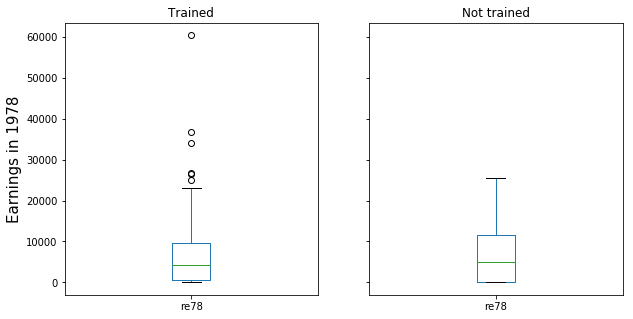

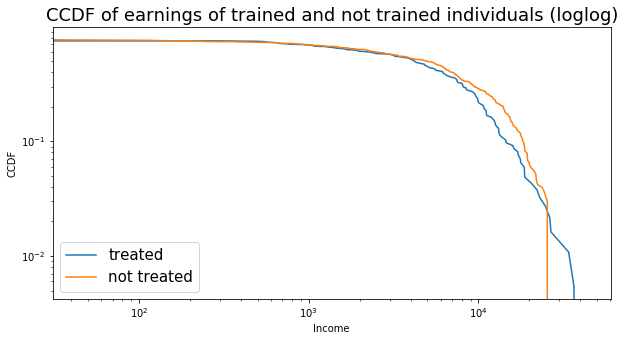

In [142]:
print_1978_earnings(data)

A naive researcher may conclude that, except for some outliers, the training does not make a difference in determining the earnings of the cadidates

## 2 - A closer look at the data

For each feature, we compare its distribution in the control and in the treated group.

In [143]:
def get_feature(feature_name, data):
    """Returns the series corresponding to feature name.
    The returned element is a tuple of two elements, the first
    corresponding to the (treated, not_treated) group"""
    get_treated = lambda treated: data[feature_name][data.treat == treated]
    return get_treated(True), get_treated(False)

We also define functions to help in printing information about the graphs

In [144]:
def print_ccdf(feature, label):
    """Print the ccdf graph from a particular feature. Use the label as the xlabel and in the title""" 
    for cdf in map(empirical_distribution, feature):
        (1 - cdf).plot()
    plt.legend(['treated', 'control'], fontsize=15)
    plt.title('Loglog CCDF of {}'.format(label))
    plt.xlabel(label)
    plt.ylabel('CCDF')
    plt.show()

In [145]:
def print_box_plot(feature, label):
    """Print a box plot of the feature. Use the lable to set the title"""
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row')
    for ax, feature in zip(axes, feature):
        feature.plot.box(ax=ax)
    axes[0].set_title('{} of treated'.format(label.capitalize()))
    axes[1].set_title('{} of control group'.format(label.capitalize()))
    plt.show() 

In [146]:
# This array contains functions to print the analysis by property
print_analysis_properties_fcts = []

### Age

In [147]:
def print_age_info(data):
    """Function to print the age information from the specified dataframe"""
    age_groups = get_feature('age', data)
    
    # CCDF plot
    print_ccdf(age_groups, 'age')
    
    # Box plot
    print_box_plot(age_groups, 'age')
    
print_analysis_properties_fcts.append(print_age_info)

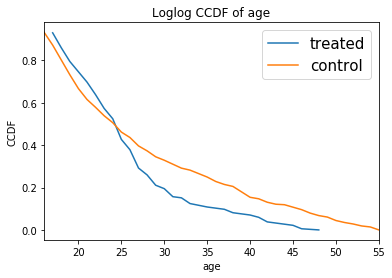

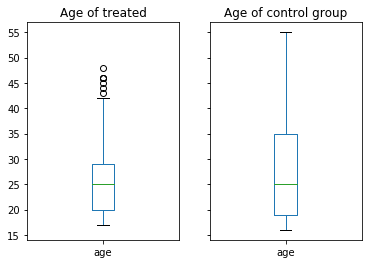

In [148]:
print_age_info(data)

We can see that the members of the treated group are in general younger than the members of the control group.
The medians are very similar, but on the upper part of the distribution, the person in the treated group are younger than the one in the control group.
This leads to think that older people had a low chance to be treated and it might reduce bias in our control group if we removed them after a certain age.

### Education years

In [149]:
def print_ed_info(data):
    ed = get_feature('educ', data)
    
    # CCDF plot
    print_ccdf(ed, 'education years')
    
    # Box plot
    print_box_plot(ed, 'education years')
print_analysis_properties_fcts.append(print_ed_info)

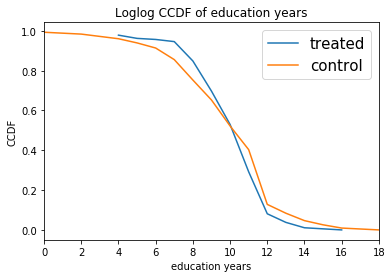

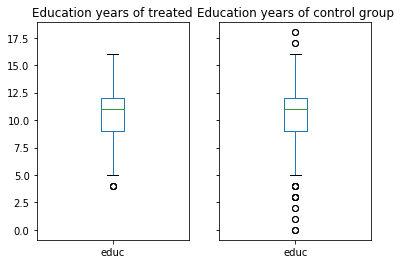

In [150]:
print_ed_info(data)

While the distributions of the variable in the two groups seem similar, the boxplot reveals an interesting detail: the control group has many outliers who studied for less than the 1/4 quantile. There's also some outliers in the maximum education years in the control group.

This might be caused by the fact that people who never studied or studied a lot tended to not get the treatment. Because of this, they might be poor subjects to add in our control group.

### Ethnicity

In [151]:
any(map(lambda tup: all(tup), data[data.hispan == data.black][['black', 'hispan']].values))

False

After having checked that there is no individual marked as both hispanic and black, we can plot the proportion of ethinicity in the the two populations:

In [152]:
def print_ethnicities_info(data):
    ethnicities = ['hispan', 'black']
    fig, axes = plt.subplots(nrows=1, ncols=2)

    for ax, treated in zip(axes, (True, False)):
        # Extract hispanic and black boolean indicators
        eths = data[data.treat == treated][ethnicities]
        # If neither black nor hispanic, add a True to indicate other category
        eths['other'] = reduce(lambda x, y: x & y, map(lambda e: ~eths[e], ethnicities)) # <3 mapreduce
        # Sum to obtain ethnic count
        eths = eths.sum(axis=0)
        # Plot
        ax.axis('equal')
        ax.set_title('Treat' if treated else 'Control')
        ax.pie(eths.values, labels=eths.index, autopct='%1.1f%%')
print_analysis_properties_fcts.append(print_ethnicities_info)

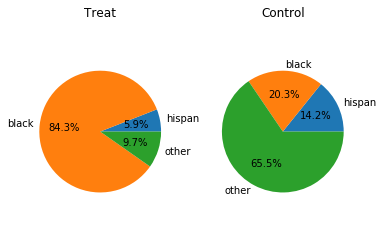

In [153]:
print_ethnicities_info(data)

This reveals an interesting fact: the control and treated populations have very different compositions. While most of the control individuals are neither black nor hispanic (can we assume white?), most of the treated population is black.

### Civil status

In [154]:
def print_civil_status_info(data):
    groups = get_feature('married', data)

    fig, axes = plt.subplots(nrows=1, ncols=2)

    for ax, g in zip(axes, groups):
        c = g.value_counts()
        ax.axis('equal')
        ax.pie(c.values, labels=['married' if t else 'not married' for t in c.index], autopct='%1.1f%%')

    axes[0].set_title('Treat')
    axes[1].set_title('Control')
    plt.show()
print_analysis_properties_fcts.append(print_civil_status_info)

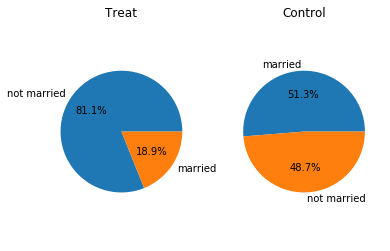

In [155]:
print_civil_status_info(data)

These piecharts highlight another important difference in population composition: most of the treated individuals are not married while almost half of the control population is married.

### Degree

In [156]:
def print_degree_info(data):
    groups = get_feature('nodegree', data)

    fig, axes = plt.subplots(nrows=1, ncols=2)

    for ax, g in zip(axes, groups):
        c = g.value_counts()
        ax.axis('equal')
        ax.pie(c.values, labels=['does not have degree' if t else 'has degree' for t in c.index],
               autopct='%1.1f%%')

    axes[0].set_title('Treat')
    axes[1].set_title('Control')
    plt.show()
print_analysis_properties_fcts.append(print_degree_info)

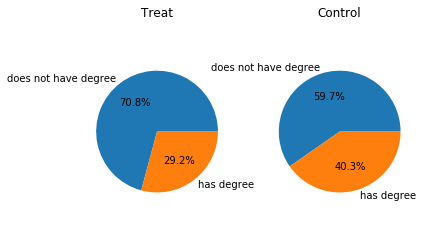

In [157]:
print_degree_info(data)

Yet another important difference: slightly more treated individuals than controlled ones have a degree, which might directly influence their earnings

### Pre-treatment earnings

In [158]:
def print_pre_treatment_earnings(data):
    features = ['re74', 're75']
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='row', figsize=(12, 12))

    for cell, year in zip(axes[0], features):
        for treated in (True, False):
            earnings = data[data.treat == treated][features]
            cell.plot(1 - empirical_distribution(earnings[year]))
            cell.set_xlabel('x (log)')
            cell.set_ylabel('P(earn > x) (log)')
        cell.legend(['treated', 'not treated'])
        cell.set_title(year + ' distribution')           

    for cell, year in zip(axes[1], features):
        cell.boxplot([data[year][data.treat == treated].values for treated in (True, False)])
        cell.set_xticklabels(['treated', 'not treated'])
        cell.set_title(year + ' comparison')
print_analysis_properties_fcts.append(print_pre_treatment_earnings)

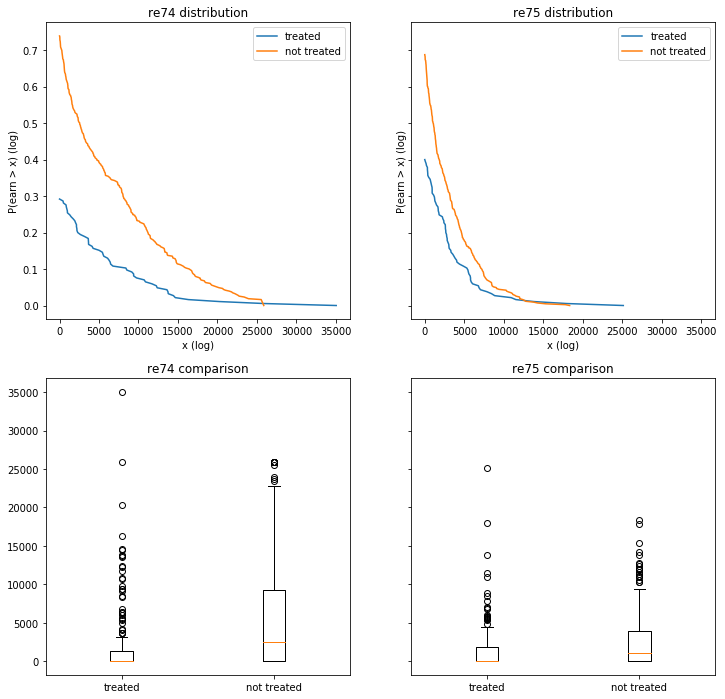

In [159]:
print_pre_treatment_earnings(data)

We observe that the control population had higher earnings than the treated population before the the treatment.

In fact, most of the treated population had no income before the treatment, which might show a bias in treatment towards individuals with no income.

Also, the not treated population had a major reduction in their income distribution after only 1 year.
It implies that many people considered for the not treated population already had work experience prior to the test, but lost their job recently.
This might create a bias in the not treated population, because it is likely that someone with previous work experience has better odds of finding a job than someone with no work experience or long term previous unemployment.

## 3 - A propensity score model

In [160]:
data.dtypes

id           object
treat          bool
age           uint8
educ          int64
black          bool
hispan         bool
married        bool
nodegree       bool
re74        float32
re75        float32
re78        float32
dtype: object

In [161]:
boolean_features = ['treat', 'black', 'hispan', 'married', 'nodegree']

no_id = data.loc[:, data.columns != 'id']
no_id = no_id.loc[:, no_id.columns != 're78'].copy() # Based on pre-treatment features => exclude post treatment features

for feat in boolean_features:
    no_id.loc[:, feat] = no_id[feat].astype(np.uint8)

In [162]:
print('Features used for propensity score computation:')
[col for col in no_id.columns]

Features used for propensity score computation:


['treat',
 'age',
 'educ',
 'black',
 'hispan',
 'married',
 'nodegree',
 're74',
 're75']

In [163]:
x_train = no_id.loc[:, no_id.columns != 'treat'].as_matrix()
y_train = no_id.loc[:, 'treat'].as_matrix()

In [164]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predictions = lr.predict_proba(x_train)

In [165]:
predictions.shape, np.all(np.sum(predictions, axis=1))

((614, 2), True)

`predict_proba` returns a bidimensional array which has as many rows as data points and as many columns as classification classes. We are interested in the propensity score which is the probability of receiving the treatment. Therefore we want the second column of `predictions`

In [166]:
# Rebuild indexed series
propensities = pd.Series(predictions[:, 1], index=no_id.index)
propensities.name = "propensity"
display(propensities.head())

0    0.443350
1    0.144660
2    0.722355
3    0.664151
4    0.698286
Name: propensity, dtype: float64

To have simple access, we will merge the propensity scores with the data DataFrame.

In [167]:
data_prop = pd.concat([data, propensities], axis=1) 
display(data_prop.head(5))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898,0.443350
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043,0.144660
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219,0.722355
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996,0.664151
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886,0.698286


## 4 - Balancing the dataset via matching

We now want to balance the dataset by using the propensity score we calculated. The goal is to match each treated subject with a not treated subject that has a similar propensity score. 

To do so, we will realize a bipartite graph using the networkx library.

### Create a matched dataset

In [168]:
# Create sub dataframes that will be used to realize the matching
treated_prop = data_prop[data_prop['treat'] == True]
not_treated_prop = data_prop[data_prop['treat'] == False]

# Make sure that there's more people that where not treated than people that where treated
# This is mandatory for our matching algorithm
print("Number of treated: {}\nNumber of not treated: {}".format(len(treated_prop), len(not_treated_prop)))

# Created an empty graph
linked_graph = nx.Graph()

# We will use the modified_not_treated_prop as a dataframe of the nodes that are NOT linked
modified_not_treated_prop = not_treated_prop

# We will find the not treated node to link with each treated node, we first loop through the treated nodes
for row in treated_prop.sort_values('propensity').itertuples():
        # Get a map of the absolute difference of the propensity value for each remaining not treated person
        # The map elements are tuples of (index, abs_diff)
        map_val = map( lambda item: (item.Index,abs(item.propensity-row.propensity)),
                       modified_not_treated_prop.itertuples())
        # Extract the minimum value and its index
        min_val = min(map_val,  key= lambda x: x[1])
        
        # We create a graph with the resulting index as node identifiant
        # This allows for validation of the method
        linked_graph.add_node(row.Index, bipartite=0)
        linked_graph.add_node(min_val[0], bipartite=1)
        linked_graph.add_edge(row.Index, min_val[0], weight=min_val[1])
        
        # We drop the used row from the not treated person dataframe, this avoid having two edges toward
        # the same node
        # Note: This methodology doesn't ensure minimum overall weight, but should be pretty close!
        modified_not_treated_prop = modified_not_treated_prop.drop(min_val[0])

Number of treated: 185
Number of not treated: 429


In [169]:
# Validate that our graph has the properties we are looking for
print(nx.info(linked_graph))

# TODO: How can we make sure that we obtain a minimal total weight? We should be pretty close, but we can't be sure
#       with the method used
print("Total weight: {:.3f}".format(linked_graph.size(weight='weight')))

Name: 
Type: Graph
Number of nodes: 370
Number of edges: 185
Average degree:   1.0000
Total weight: 44.179


In [171]:
# Create the dataframe of the nodes we didn't drop

linked_not_treated_prop = not_treated_prop.drop(modified_not_treated_prop.index)
display(linked_not_treated_prop.head())

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
189,PSID5,False,25,9,True,False,True,True,14829.690430,13776.530273,0.000000,0.416054
190,PSID6,False,37,9,True,False,True,True,13685.480469,12756.049805,17833.199219,0.402995
192,PSID8,False,20,12,True,False,False,False,7392.313965,12396.190430,17765.230469,0.765043
199,PSID15,False,22,14,True,False,True,False,748.439880,11105.370117,18208.550781,0.650250
200,PSID16,False,42,0,False,True,True,True,2797.833008,10929.919922,9922.933594,0.149084


In [172]:
matched_data = pd.merge(treated_prop, linked_not_treated_prop, how='outer')
display(matched_data.head(5))
display(matched_data.tail(5))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898,0.443350
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043,0.144660
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219,0.722355
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996,0.664151
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886,0.698286


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
365,PSID423,False,27,10,True,False,False,True,0.0,0.0,7543.793945,0.678714
366,PSID424,False,25,14,False,False,False,False,0.0,0.0,0.000000,0.151072
367,PSID427,False,21,18,False,False,False,False,0.0,0.0,0.000000,0.123129
368,PSID428,False,32,5,True,False,True,True,0.0,0.0,187.671295,0.550460
369,PSID429,False,16,9,False,False,False,True,0.0,0.0,1495.458984,0.155030


### Outcome comparison

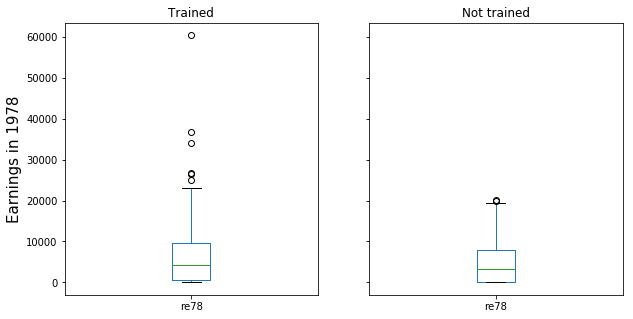

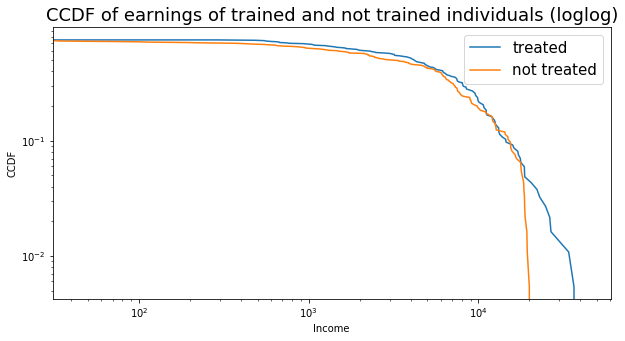

In [173]:
print_1978_earnings(matched_data)

We can see that the trained actually had an increase in income compared to the not trained when we use this selection.

Indeed, their median income is higher. Also, we can see that there's more high paid trained persons.

### Value distribution comparisons

In [174]:
# Lets check how many analysis function we have
print(len(print_analysis_properties_fcts))

6


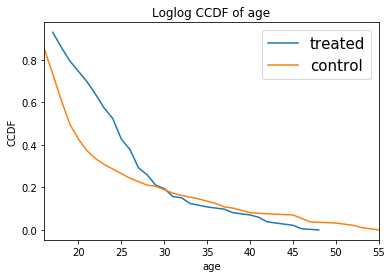

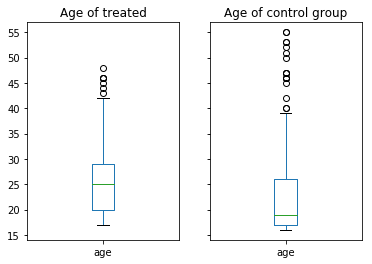

In [175]:
print_analysis_properties_fcts[0](matched_data)

We can see that the age is not evenly distributed in the matched group. There's more very young person ($<20$ years old in the control group. This might be a bias, especially in salary: a 15 years old will likely have a big difference in income with a 25 years old.

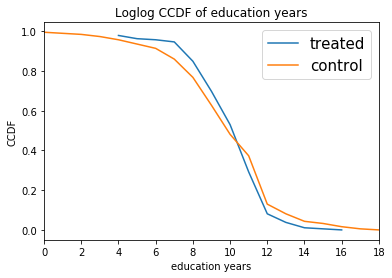

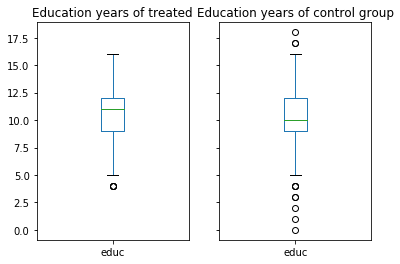

In [176]:
print_analysis_properties_fcts[1](matched_data)

We can see that we have brought the median age down in the control group with our selection.

The selection didn't remove the outliers from the dataset, this might have been a desirable thing to do.

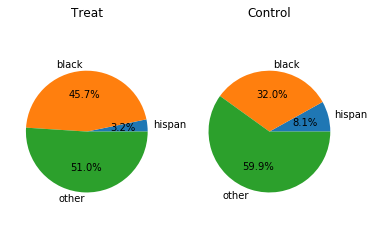

In [177]:
print_analysis_properties_fcts[2](matched_data)

We can see that the proportion of "Black" has increased in the control set.
The ethnicity parameters don't match in both groups yet though, but it is closer than previously.

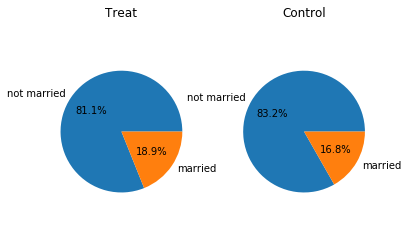

In [178]:
print_analysis_properties_fcts[3](matched_data)

We can see that the married are really close matches compared to the previous results. 


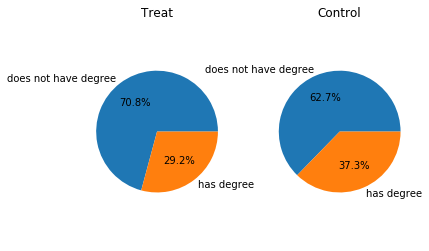

In [179]:
print_analysis_properties_fcts[4](matched_data)

We can see that the degree distribution has barely changed in the control dataset.
Though, intuition tends to give it a high importance in the employment.
We should try to match those values more closely.

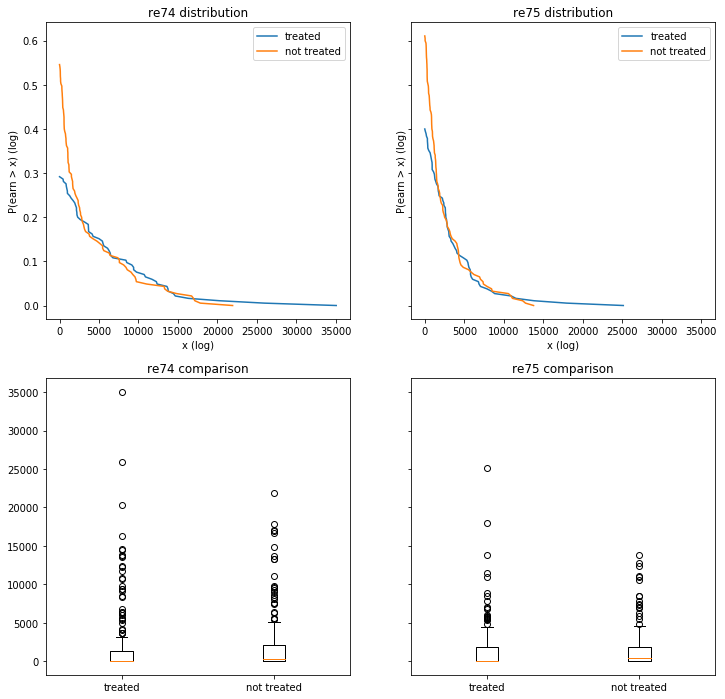

In [180]:
print_analysis_properties_fcts[5](matched_data)

The income match is way closer than previously. 
There's still outliers in the dataset, but we can see that the not treated curve now follows the treated curve more closely.

From this second analysis it seems that the previous income distribution and the marital status are close enough together.

The education is pretty close, but the outliers could be removed from the matched profile.


The age, ethnicity and degree parameter would still need to be adjusted to have a better fit.

## Balancing the groups further

In this section, we will attempt to balance the indicators that where not fully satisfying.

Those indicators are the education outliers, the age, the ethnicity and the degree.

For the education, we will filter out the outliers.

For the age, we will force the matches to be within 3 years of each other.

For the ethnicity and the degree, we will force at least one of the two to be shared between matches.

### Creating a matched dataset with preferential treatment

In [285]:
# Create sub dataframes that will be used to realize the matching
treated_prop = data_prop[data_prop['treat'] == True]
not_treated_prop = data_prop[data_prop['treat'] == False]

# *******************ADDED FOR PREFERENTIAL********************
MAX_AGE_DIFF = 100

# Remove the outlier data in the education years metric.
# We see from the graph above that the outliers are below 4 years of education and above 16 years
rows_to_keep = list(filter(lambda row : row.educ >= 4 and row.educ <=16,
                         not_treated_prop.itertuples()))
not_treated_prop = pd.DataFrame(rows_to_keep)

def compare_ethnicity(index, row, df):
    return (df['black'][index] == row.black) and \
           (df['hispan'][index] == row.hispan)

def compare_degree(index, row, df):
    return df['nodegree'][index] == row.nodegree

def compare_age(index, row, df):
    return abs(df['age'][index]-row.age) <= MAX_AGE_DIFF
        
# ****************END OF ADDED FOR PREFERENTIAL****************


# Make sure that there's more people that where not treated than people that where treated
# This is mandatory for our matching algorithm
print("Number of treated: {}\nNumber of not treated: {}".format(len(treated_prop), len(not_treated_prop)))

# Created an empty graph
linked_graph = nx.Graph()

# We will use the modified_not_treated_prop as a dataframe of the nodes that are NOT linked
modified_not_treated_prop = not_treated_prop

ite=0
# We will find the not treated node to link with each treated node, we first loop through the treated nodes
for row in treated_prop.sort_values('propensity').itertuples():
        ite +=1
        # Get a map of the absolute difference of the propensity value for each remaining not treated person
        # The map elements are tuples of (index, abs_diff)
        map_val = map( lambda item: (item.Index,abs(item.propensity-row.propensity)),
                       modified_not_treated_prop.itertuples())
        
        # Remove any index that is already in the network
        map_val = list(filter(lambda val: not linked_graph.has_node(val[0]) ,map_val))
        
        # *******************ADDED FOR PREFERENTIAL********************
        
        # Create a new preferential selection before doing the minimal value selection
        
        # We start by matching ethnicity or degree
        filtered_index = list(filter(lambda val: compare_ethnicity(val[0], row, modified_not_treated_prop) or \
                                                 compare_degree(val[0], row, modified_not_treated_prop),
                                            map_val))
        # Make sure that there's always some value to chose from
        if len(filtered_index) == 0:
            filtered_index = map_val
        else:
            age_filtered_index = list(filter(lambda val: compare_age(val[0], row, modified_not_treated_prop),
                                             filtered_index))
            # We only filter for age if there's a match
            if len(age_filtered_index) != 0:
                filtered_index = age_filtered_index
                
        # ****************END OF ADDED FOR PREFERENTIAL****************
        
        # Extract the minimum value and its index
        min_val = min(filtered_index,  key= lambda x: x[1])
        
        # We create a graph with the resulting index as node identifiant
        # This allows for validation of the method
        linked_graph.add_node(row.Index, bipartite=0)
        linked_graph.add_node(min_val[0], bipartite=1)
        linked_graph.add_edge(row.Index, min_val[0], weight=min_val[1])
        
        # We drop the used row from the not treated person dataframe, this avoid having two edges toward
        # the same node
        # Note: This methodology doesn't ensure minimum overall weight, but should be pretty close!
        modified_not_treated_prop = modified_not_treated_prop.drop(min_val[0])
        print(ite, linked_graph.number_of_nodes(), linked_graph.number_of_edges(), row.Index, min_val[0])
        

Number of treated: 185
Number of not treated: 413
1 2 1 123 184 0
2 4 2 166 157 0
3 6 3 43 250 0
4 8 4 9 221 0
5 10 5 136 156 0
6 12 6 172 142 0
7 14 7 128 301 0
8 16 8 176 189 0
9 18 9 124 95 0
10 20 10 181 317 0
11 22 11 75 340 0
12 24 12 27 329 0
13 26 13 59 84 0
14 28 14 22 228 0
15 30 15 99 262 0
16 32 16 21 260 0
17 34 17 115 209 0
18 36 18 1 194 0
19 38 19 111 395 0
20 40 20 139 229 0
21 42 21 86 173 0
22 44 22 41 258 0
23 46 23 82 174 0
24 48 24 67 182 0
25 50 25 178 160 0
26 51 26 95 371 0
27 53 27 88 202 0
28 55 28 144 147 0
29 57 29 165 94 0
30 59 30 179 154 0
31 60 31 174 296 0
32 62 32 180 89 0
33 64 33 162 25 0
34 66 34 133 56 0
35 67 35 182 361 0
36 69 36 109 90 0
37 71 37 0 354 0
38 72 38 90 248 0
39 74 39 51 38 0
40 76 40 54 394 0
41 77 41 25 92 0
42 79 42 171 319 0
43 81 43 32 4 0
44 83 44 45 341 0
45 85 45 114 366 0
46 87 46 134 281 0
47 89 47 58 5 0
48 91 48 13 411 0
49 92 49 38 91 0
50 94 50 132 227 0
51 96 51 183 126 0
52 98 52 127 314 0
53 100 53 148 318 0
54 102

In [280]:
# Validate that our graph has the properties we are looking for
print(nx.info(linked_graph))

# TODO: How can we make sure that we obtain a minimal total weight? We should be pretty close, but we can't be sure
#       with the method used
print("Total weight: {:.3f}".format(linked_graph.size(weight='weight')))

Name: 
Type: Graph
Number of nodes: 334
Number of edges: 185
Average degree:   1.1078
Total weight: 51.717


In [233]:
# Create the dataframe of the nodes we didn't drop
linked_not_treated_prop = not_treated_prop.drop(modified_not_treated_prop.index)
display(linked_not_treated_prop.head())

,Index,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
4,189,PSID5,False,25,9,True,False,True,True,14829.690430,13776.530273,0.000000,0.416054
5,190,PSID6,False,37,9,True,False,True,True,13685.480469,12756.049805,17833.199219,0.402995
7,192,PSID8,False,20,12,True,False,False,False,7392.313965,12396.190430,17765.230469,0.765043
12,197,PSID13,False,34,8,False,False,True,True,8038.872070,11404.349609,5486.798828,0.072905
14,199,PSID15,False,22,14,True,False,True,False,748.439880,11105.370117,18208.550781,0.650250


In [234]:
pref_matched_data = pd.merge(treated_prop, linked_not_treated_prop, how='outer')
display(pref_matched_data.head(5))
display(pref_matched_data.tail(5))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity,Index
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898,0.443350,NaN
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043,0.144660,NaN
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219,0.722355,NaN
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996,0.664151,NaN
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886,0.698286,NaN


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity,Index
365,PSID418,False,27,12,False,False,True,False,0.0,0.0,1533.880005,0.079494,602.0
366,PSID419,False,51,4,True,False,False,True,0.0,0.0,0.000000,0.727295,603.0
367,PSID423,False,27,10,True,False,False,True,0.0,0.0,7543.793945,0.678714,607.0
368,PSID424,False,25,14,False,False,False,False,0.0,0.0,0.000000,0.151072,608.0
369,PSID428,False,32,5,True,False,True,True,0.0,0.0,187.671295,0.550460,612.0


### Outcome comparison

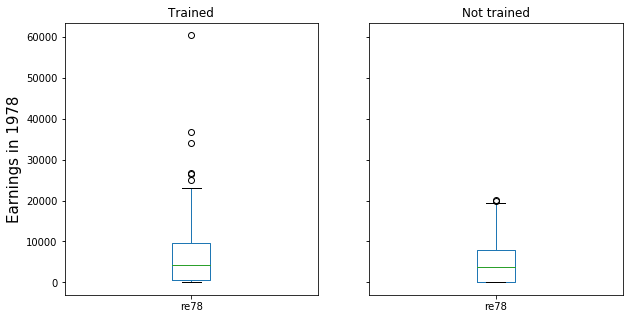

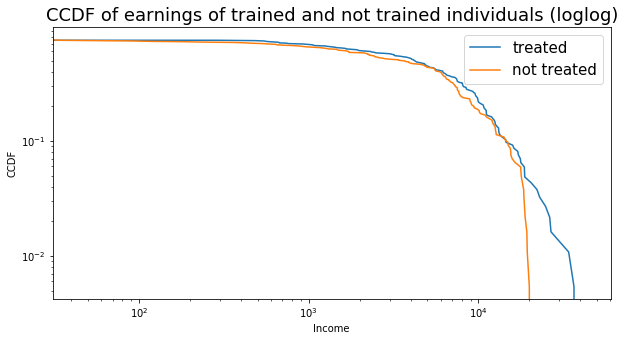

In [221]:
print_1978_earnings(pref_matched_data)

### Value distribution comparisons

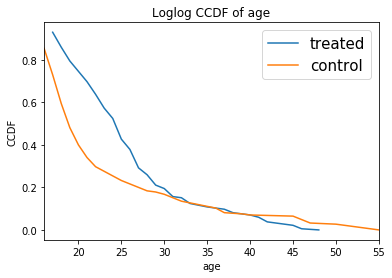

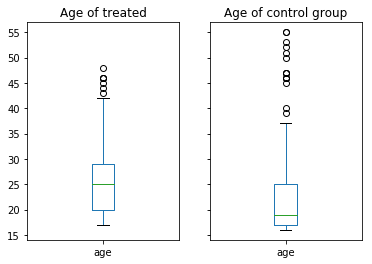

In [222]:
print_analysis_properties_fcts[0](pref_matched_data)

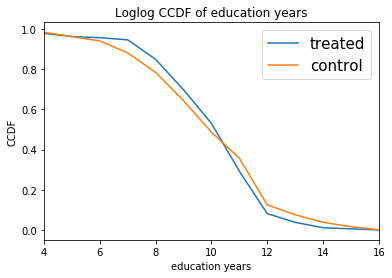

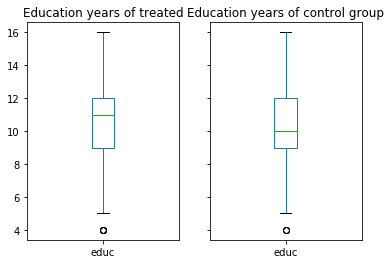

In [223]:
print_analysis_properties_fcts[1](pref_matched_data)

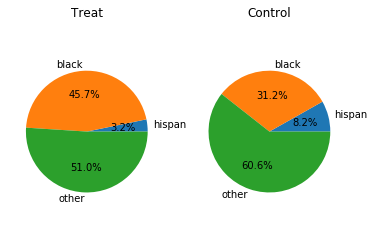

In [224]:
print_analysis_properties_fcts[2](pref_matched_data)

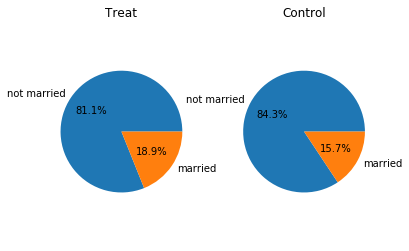

In [225]:
print_analysis_properties_fcts[3](pref_matched_data)

We can see that the married are really close matches compared to the previous results. 


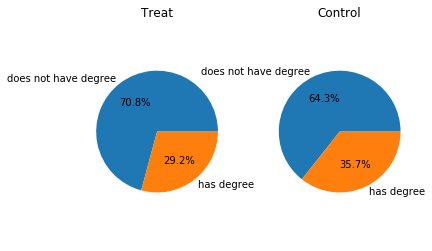

In [226]:
print_analysis_properties_fcts[4](pref_matched_data)

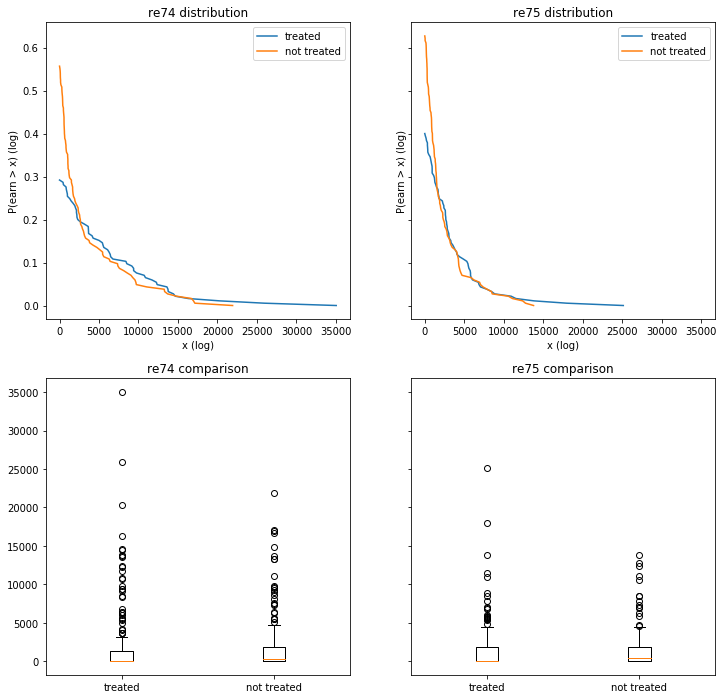

In [227]:
print_analysis_properties_fcts[5](pref_matched_data)